# 1-1

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
def conv2d(image, kernel):
    image_height, image_width, channels = image.shape
    kernel_height, kernel_width, _ = kernel.shape
    padded_image = np.pad(image, ((kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2), (0, 0)), mode='constant')
    output_height = image_height
    output_width = image_width
    output = np.zeros((output_height, output_width, channels))
    for i in range(output_height):
        for j in range(output_width):
            for c in range(channels):
                output[i, j, c] = np.sum(padded_image[i:i+kernel_height, j:j+kernel_width, c] * kernel[:, :, c])
    return output

In [94]:
image = np.array(Image.open('D:/Neural Networks/NNHW4/fruits.jpg'))

In [16]:
filters = np.random.rand(4, 3, 3, 3)

In [17]:
outputs = np.zeros((4, image.shape[0], image.shape[1], 3))
for i, kernel in enumerate(filters):
    outputs[i] = conv2d(image, kernel)

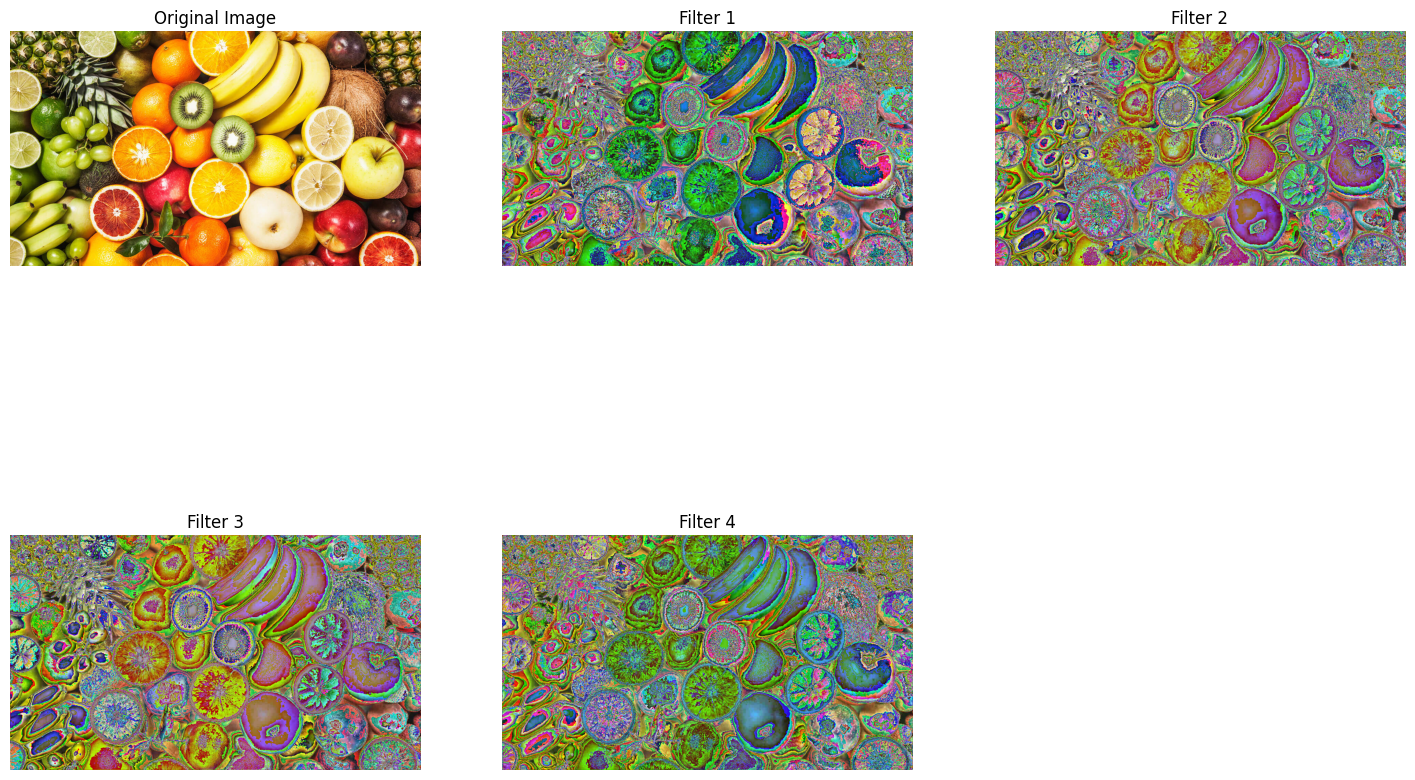

In [20]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(image.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')
for i in range(outputs.shape[0]):
    plt.subplot(2, 3, i + 2)
    plt.imshow(outputs[i].astype(np.uint8))
    plt.title(f"Filter {i + 1}")
    plt.axis('off')
plt.show()

# 1-2

In [104]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.biases = np.zeros((out_channels, 1))
    
    def forward(self, x):
        padded_input = np.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        batch_size, height, width, _ = padded_input.shape
        out_height = height - self.kernel_size + 1
        out_width = width - self.kernel_size + 1
        output = np.zeros((batch_size, out_height, out_width, self.out_channels))

        for b in range(batch_size):
            for i in range(out_height):
                for j in range(out_width):
                    for c_out in range(self.out_channels):
                        for c_in in range(self.in_channels):
                            output[b, i, j, c_out] += np.sum(
                                padded_input[b, i:i+self.kernel_size, j:j+self.kernel_size, c_in] * self.weights[c_out, c_in]
                            )
                        output[b, i, j, c_out] += self.biases[c_out]
        return output

class BatchNorm:
    def __init__(self, num_features, epsilon=1e-5, momentum=0.9):
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros((num_features,))
        self.running_var = np.zeros((num_features,))
        self.num_features = num_features
        self.gamma = np.ones((num_features,))
        self.beta = np.zeros((num_features,))
    
    def forward(self, x):
        if len(x.shape) == 4:  # If input is a batch of images
            mean = np.mean(x, axis=(0, 1, 2))
            var = np.var(x, axis=(0, 1, 2))
            x_normalized = (x - mean) / np.sqrt(var + self.epsilon)
            out = self.gamma * x_normalized + self.beta
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        elif len(x.shape) == 2:  # If input is a batch of fully connected features
            mean = np.mean(x, axis=0)
            var = np.var(x, axis=0)
            x_normalized = (x - mean) / np.sqrt(var + self.epsilon)
            out = self.gamma * x_normalized + self.beta
        return out

class ReLU:
    def forward(self, x):
        return np.maximum(0, x)

class MaxPool2D:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
    
    def forward(self, x):
        batch_size, height, width, channels = x.shape
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1
        output = np.zeros((batch_size, out_height, out_width, channels))
        for b in range(batch_size):
            for i in range(out_height):
                for j in range(out_width):
                    for c in range(channels):
                        output[b, i, j, c] = np.max(x[b, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size, c])
        return output

class Dropout:
    def __init__(self, dropout_prob):
        self.dropout_prob = dropout_prob
        self.mask = None
    
    def forward(self, x, is_training):
        if is_training:
            self.mask = np.random.rand(*x.shape) < self.dropout_prob
            return x * self.mask
        else:
            return x * (1 - self.dropout_prob)

class FullyConnected:
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features)
        self.biases = np.zeros((out_features,))
    
    def forward(self, x):
        return np.dot(x, self.weights) + self.biases

class Softmax:
    def forward(self, x):
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

In [126]:
conv1 = Conv2D(in_channels=3, out_channels=4, kernel_size=3, padding=1)
bn1 = BatchNorm(num_features=4)
relu1 = ReLU()
conv2 = Conv2D(in_channels=4, out_channels=8, kernel_size=3, padding=1)
relu2 = ReLU()
maxpool1 = MaxPool2D(pool_size=2, stride=2)
conv3 = Conv2D(in_channels=8, out_channels=16, kernel_size=3, padding=1)
bn2 = BatchNorm(num_features=16)
relu3 = ReLU()
conv4 = Conv2D(in_channels=16, out_channels=16, kernel_size=3, padding=1)
relu4 = ReLU()
maxpool2 = MaxPool2D(pool_size=2, stride=2)
dropout1 = Dropout(dropout_prob=0.05)
conv5 = Conv2D(in_channels=16, out_channels=32, kernel_size=3, padding=1)
bn3 = BatchNorm(num_features=32)
relu5 = ReLU()
conv6 = Conv2D(in_channels=32, out_channels=32, kernel_size=3, padding=1)
relu6 = ReLU()
maxpool3 = MaxPool2D(pool_size=2, stride=2)
dropout2 = Dropout(dropout_prob=0.1)
fc1 = FullyConnected(in_features=408000, out_features=64)
relu7 = ReLU()
dropout3 = Dropout(dropout_prob=0.1)
fc2 = FullyConnected(in_features=64, out_features=32)
relu8 = ReLU()
dropout4 = Dropout(dropout_prob=0.1)
fc3 = FullyConnected(in_features=32, out_features=2)
softmax = Softmax()

In [107]:
x = image.reshape(1, 1200, 686, 3)
out_conv1 = conv1.forward(x)
out_bn1 = bn1.forward(out_conv1)
out_relu1 = relu1.forward(out_bn1)

In [108]:
out_conv2 = conv2.forward(out_relu1)
out_relu2 = relu2.forward(out_conv2)

In [109]:
out_maxpool1 = maxpool1.forward(out_relu2)

In [110]:
out_conv3 = conv3.forward(out_maxpool1)
out_bn2 = bn2.forward(out_conv3)
out_relu3 = relu3.forward(out_bn2)

In [111]:
out_conv4 = conv4.forward(out_relu3)
out_relu4 = relu4.forward(out_conv4)

In [112]:
out_maxpool2 = maxpool2.forward(out_relu4)
out_dropout1 = dropout1.forward(out_maxpool2, is_training=True)

In [113]:
out_conv5 = conv5.forward(out_dropout1)
out_bn3 = bn3.forward(out_conv5)
out_relu5 = relu5.forward(out_bn3)

In [114]:
out_conv6 = conv6.forward(out_relu5)
out_relu6 = relu6.forward(out_conv6)

In [115]:
out_maxpool3 = maxpool3.forward(out_relu6)

In [119]:
out_flatten = out_maxpool3.reshape(out_maxpool3.shape[0], -1)

In [121]:
num_features = out_maxpool3.shape[1] * out_maxpool3.shape[2] * out_maxpool3.shape[3]
out_flatten = out_maxpool3.reshape(out_maxpool3.shape[0], num_features)

In [127]:
out_fc1 = fc1.forward(out_flatten)
out_relu7 = relu7.forward(out_fc1)
out_dropout3 = dropout3.forward(out_relu7, is_training=True)

In [128]:
out_fc2 = fc2.forward(out_dropout3)
out_relu8 = relu8.forward(out_fc2)
out_dropout4 = dropout4.forward(out_relu8, is_training=True)
out_fc3 = fc3.forward(out_dropout4)

In [130]:
out_softmax = softmax.forward(out_fc3)

print(out_softmax)

[[0.817 0.183]]


# 2-1

In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


batch_size = 64
learning_rate = 0.001
num_epochs = 20


transform = transforms.Compose([transforms.ToTensor()])

In [158]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [159]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(14*14*16, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [167]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(14*14*16, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [161]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [162]:
model_2layer = CNN2().to(device)


criterion = nn.CrossEntropyLoss()
optimizer_2layer = optim.Adam(model_2layer.parameters(), lr=learning_rate)
optimizer_4layer = optim.Adam(model_4layer.parameters(), lr=learning_rate)

In [163]:
def train(model, optimizer):
    total_step = len(train_loader)
    loss_list = []
    accuracy_list = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        accuracy = 100 * correct / total
        loss_list.append(loss.item())
        accuracy_list.append(accuracy)

    return loss_list, accuracy_list

In [164]:
loss_2layer, accuracy_2layer = train(model_2layer, optimizer_2layer)

Epoch [1/20], Step [100/938], Loss: 0.2605
Epoch [1/20], Step [200/938], Loss: 0.2132
Epoch [1/20], Step [300/938], Loss: 0.0590
Epoch [1/20], Step [400/938], Loss: 0.0724
Epoch [1/20], Step [500/938], Loss: 0.0781
Epoch [1/20], Step [600/938], Loss: 0.2536
Epoch [1/20], Step [700/938], Loss: 0.3063
Epoch [1/20], Step [800/938], Loss: 0.0448
Epoch [1/20], Step [900/938], Loss: 0.1406
Epoch [2/20], Step [100/938], Loss: 0.1378
Epoch [2/20], Step [200/938], Loss: 0.0972
Epoch [2/20], Step [300/938], Loss: 0.1124
Epoch [2/20], Step [400/938], Loss: 0.0499
Epoch [2/20], Step [500/938], Loss: 0.0371
Epoch [2/20], Step [600/938], Loss: 0.0602
Epoch [2/20], Step [700/938], Loss: 0.0369
Epoch [2/20], Step [800/938], Loss: 0.0491
Epoch [2/20], Step [900/938], Loss: 0.1555
Epoch [3/20], Step [100/938], Loss: 0.0500
Epoch [3/20], Step [200/938], Loss: 0.0583
Epoch [3/20], Step [300/938], Loss: 0.0822
Epoch [3/20], Step [400/938], Loss: 0.1310
Epoch [3/20], Step [500/938], Loss: 0.0806
Epoch [3/20

In [168]:
model_1layer = CNN1().to(device)

In [169]:
criterion = nn.CrossEntropyLoss()
optimizer_1layer = optim.Adam(model_1layer.parameters(), lr=learning_rate)

In [170]:
loss_1layer, accuracy_1layer = train(model_1layer, optimizer_1layer)

Epoch [1/20], Step [100/938], Loss: 0.3413
Epoch [1/20], Step [200/938], Loss: 0.1139
Epoch [1/20], Step [300/938], Loss: 0.1552
Epoch [1/20], Step [400/938], Loss: 0.0837
Epoch [1/20], Step [500/938], Loss: 0.1153
Epoch [1/20], Step [600/938], Loss: 0.0736
Epoch [1/20], Step [700/938], Loss: 0.0859
Epoch [1/20], Step [800/938], Loss: 0.3799
Epoch [1/20], Step [900/938], Loss: 0.2124
Epoch [2/20], Step [100/938], Loss: 0.0731
Epoch [2/20], Step [200/938], Loss: 0.0185
Epoch [2/20], Step [300/938], Loss: 0.0787
Epoch [2/20], Step [400/938], Loss: 0.0785
Epoch [2/20], Step [500/938], Loss: 0.1640
Epoch [2/20], Step [600/938], Loss: 0.0793
Epoch [2/20], Step [700/938], Loss: 0.1484
Epoch [2/20], Step [800/938], Loss: 0.0976
Epoch [2/20], Step [900/938], Loss: 0.0128
Epoch [3/20], Step [100/938], Loss: 0.0204
Epoch [3/20], Step [200/938], Loss: 0.0744
Epoch [3/20], Step [300/938], Loss: 0.2309
Epoch [3/20], Step [400/938], Loss: 0.0509
Epoch [3/20], Step [500/938], Loss: 0.1676
Epoch [3/20

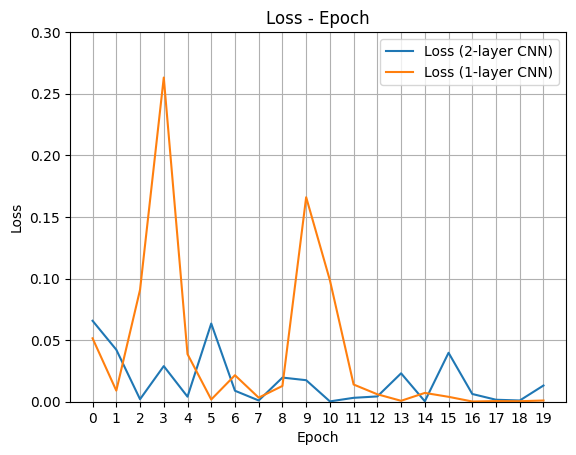

In [181]:
plt.plot(loss_2layer, label='Loss (2-layer CNN)')
plt.plot(loss_1layer, label='Loss (1-layer CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss - Epoch')
plt.legend()
plt.grid(True)
plt.xticks(range(0,20))
plt.ylim(0,0.3)
plt.show()

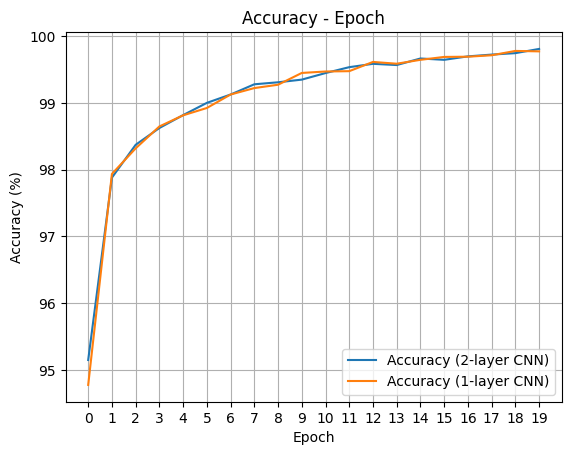

In [180]:
plt.plot(accuracy_2layer, label='Accuracy (2-layer CNN)')
plt.plot(accuracy_1layer, label='Accuracy (1-layer CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy - Epoch')
plt.legend()
plt.grid(True)
plt.xticks(range(0,20))
plt.show()

### علت عملکرد خوب هر دو شبکه اولا به خاطر فیلترهای کانولوشنی است که تصویر را به صورت یک ماتریس میبیند و پیکسل های کنار هم را با هم میبیند. یعنی شبکه های کانولوشنی نسبت به فید فوروارد ریسپتیو فیلد دارند. همچنین به دلیل استفاده از بچ نرم هر دو شبکه عملکرد بهینه ای داشته اند و هر دو شبکه بعد از گذشت 6 مرحله آموزش به دقت بالای 99 درصدرسیده اند. از آنجایی که بهترین شبکه، شبکه ساده تر است لذا شبکه کانولوشنی تک لایه عملکرد بهتری نسبت به شبکه 2 لایه داشته است و انتخاب ما برای حل این مساله هم همین شبکه است. 

# 

## 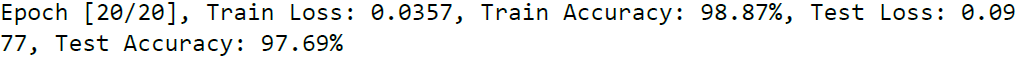

### 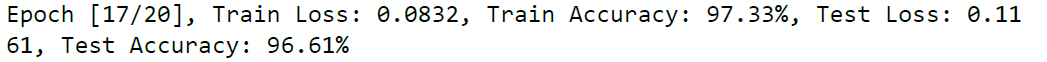

### بالاترین دقت هایی که در تمرین گذشته بنده برای این مساله به دست آمده بود دقت 97.69 (در قسمت بهینه ساز آدام) و دقت 96.61 (در قسمت بچ نرم) بود. در این تمرین با استفاده از شبکه کانولوشنی دقت99.71 به دست آمده است.  

# 

# 2-2

## این سوال در گوگل کولب اجرا شد و در یک نوت بوک جداگانه ذخیره شده است. 